<h2>Hand written digit classification via Convolutional Neural Network</h2>


some text

<h3>1. Data collection</h3><br>
The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.
<br><br>
Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.
<br><br>
The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.
<br><br>
Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).
<br><br>
<b>DataSet:</b> [MNIST](https://www.kaggle.com/c/digit-recognizer/data)

In [103]:
import matplotlib.pyplot as plt
import numpy as np

# import pickle
# import os
# import download

# import pywrap_tensorflow 
import keras
from keras import layers
from keras import models
from keras.datasets import mnist
from keras.utils import to_categorical
from keras import optimizers
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau 
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf

# pylint: disable=E0611
import utils.dataloader
from utils.dataloader import load_mnist_data #noqa
from utils.config import get_config_from_json
from mltools.plot import plotlib

import pandas as pd

import seaborn as sns

from sklearn.metrics import confusion_matrix

<h3>Definition</h3>
Load some configurations and perform some initial definitions.

In [104]:
# Definitions 
# ===================================================================

_, config_dict = get_config_from_json('configs/imageprocessing.json')

# We know that MNIST images are 28 pixels in each dimension.
image_size = config_dict['mnist']['image_size']

# Images are stored in one-dimensional arrays of this length.
image_size_flat = image_size * image_size

# Tuple with height and width of images used to reshape arrays.
image_shape = (image_size, image_size)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = config_dict['mnist']['num_channels']

# Number of classes, one class for each of 10 digits.
num_classes = config_dict['mnist']['num_classes']

batch_size = config_dict['mnist']['batch_size']

# Number of epochs
epochs = config_dict['mnist']['epochs']

# Number of epochs
maxepochs = config_dict['mnist']['maxepochs']

directory = config_dict['mnist']['directory']
data_path_mnist = directory + '/' + config_dict['mnist']['data_mnist']


<h3>Exploratory Data Analysis (EDA)</h3>

2. Exploratory Data Analysis (EDA)<br>
2.1 Load dataset<br>
2.2 Check for null and missing values<br>
2.3 Normalization<br>
2.4 Reshape<br>
2.5 Label encoding<br>
2.6 Split training and valdiation set<br>

<h4>Load dataset</h4>

In [105]:
print('Keras {}'.format(keras.__version__))
print('Tensorflow {}'.format(tf.VERSION))

x_train, y_train, x_test, y_test, x_val, y_val = load_mnist_data(image_size)

Keras 2.1.4
Tensorflow 1.6.0
Training data: (50000, 28, 28, 1)
Training labels: (50000, 10)
Test data: (10000, 28, 28, 1)
Test labels: (10000, 10)
Validation data: (10000, 28, 28, 1)
Validation labels: (10000, 10)


In [106]:
def decode(data):
    '''
    Decode one hot encoded array
    
    Arguments: 
    data   - one hot encoded array 
    
    return - int number 
    '''
    return np.argmax(data)

In [107]:

def decodeArray(encoded_data):
    arr = np.array([])
    
    for i in range(encoded_data.shape[0]):
        decoded_item = decode(encoded_data[i])
        arr = np.append(arr, decoded_item)
    
    arr = arr.astype('int32')
    return arr

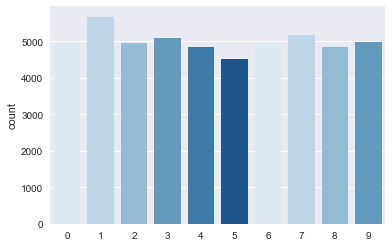

In [108]:
# Decode one hot encoded arrays
decoded = decodeArray(y_train)

palette = sns.color_palette("Blues")
sns.set(style="darkgrid")
g = sns.countplot(decoded, palette = palette)

In [109]:
# Check the data
# x_train.isnull().any().describe()

df = pd.DataFrame(decoded)
df.columns = ['label']
counts = pd.DataFrame(df['label'].value_counts())

counts

,label
1,5678
7,5175
3,5101
9,4988
2,4968
6,4951
0,4932
4,4859
8,4842
5,4506


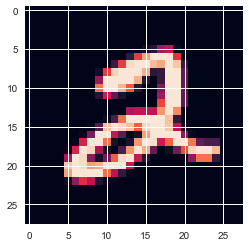

In [110]:
g = plt.imshow(x_train[5][:,:,0])

<h3>Preprocess</h3>

One step of in preprocessing the data is Normalization. Normalization has already been performed, while loading the data via 
the load_mnist_data(image_size)
x_train = x_train / 255 

In [162]:
# print(x_train[5])

## Utils
Functions used throughout the kernal.

In [112]:
def optimizer(optimizerType = 'rmsprop', learningrate = 1e4, learningrate_decay = 0.05):
    
    if optimizerType == 'rmsprop':
        opt = optimizers.RMSprop(lr = learningrate)

    if optimizerType == 'sgd':
        opt = optimizers.SGD(lr = learningrate, decay = learningrate_decay, momentum = 0.9, nesterov = True)
        
    return opt

In [113]:
def BuildModel(show = True):

    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(image_size, image_size, num_channels)))  
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation = 'relu'))
    model.add(layers.Dense(num_classes, activation = 'softmax'))
    
    if show:
        model.summary()
        
    return model

In [114]:
model = BuildModel(show = True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 3, 3, 64)          36928     
__________

<h3>Callbacks</h3>

When training a model, there are many things you can’t predict from the start.
In particular, you can’t tell how many epochs will be needed to get to an optimal validation
loss.

A much better way to handle this is to stop training when you measure that the validation
loss in no longer improving. This can be achieved using a Keras callback. A
callback is an object (a class instance implementing specific methods) that is passed to
the model in the call to fit and that is called by the model at various points during
training. It has access to all the available data about the state of the model and its performance,
and it can take action: interrupt training, save a model, load a different
weight set, or otherwise alter the state of the model.

In [115]:
modelname = 'model/weights/modelMNIST.h5'

def ModelCheckPointList(modelname):
    
    '''
    Define a list of callback functions to be used in the model as EarlyStopping, 
    ModelCheckpoint and ReduceLROnPlateau  
    
    Arguments: modelname of the best model saved
    return:    callback function as a list
    
    '''
    
    callbacks_list = [EarlyStopping(monitor = 'acc', 
                                    patience = 1,),
                  
                      ModelCheckpoint(filepath = modelname,
                                      monitor  = 'val_loss',
                                      save_best_only = True,),
                      
                      ReduceLROnPlateau(monitor='val_loss', 
                                            patience = 10, 
                                            verbose  = 1, 
                                            factor   = 0.1, 
                                            min_lr   = 0.00001)]
    return callbacks_list
                                                  

In [116]:
def EarlyStopping():
    
    '''
    Define a callback  
    
    Arguments: modelname of the best model saved
    return:    callback function as a list
    
    '''
    
    callback = EarlyStopping(monitor = 'acc', patience = 1,)
    
    return [callback]  

In [117]:
def ReduceLROnPlateau():
    
    '''
    Define a callback  
    
    Arguments: modelname of the best model saved
    return:    callback function as a list
    
    '''

    '''    
    callback = ReduceLROnPlateau(monitor  = 'val_loss', 
                                 factor   = 0.1, 
                                 patience = 10, 
                                 verbose  = 1, 
                                 mode     = 'auto', 
                                 min_delta= 0.0001, 
                                 cooldown = 0, 
                                 min_lr   = 0)
    '''
    callback = ReduceLROnPlateau(monitor  = 'val_loss', 
                                 patience = 10, 
                                 verbose  = 1, 
                                 factor   = 0.1, 
                                 min_lr   = 0.00001)
   
    return [callback]  

In [118]:
def ModelCheckPoint(modelname = 'mymodel.h5'):
    
    '''
    Define a callback checkpoint 
    
    Arguments: modelname of the best model saved
    return:    callback function as a list
    
    '''
    
    callback = ModelCheckpoint(filepath = modelname,  # model filename
                                 monitor = 'val_loss',   # quantity to monitor
                                 verbose = 0,            # verbosity - 0 or 1
                                 save_best_only = True,  # The latest best model will not be overwritten
                                 mode = 'auto')          # The decision to overwrite model is made 
                                                         # automatically depending on the quantity to monitor
    return [callback]    

In [126]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

checkpoint        = ModelCheckPoint(modelname = 'model/weights/modelMNIST.h5')
reducelronplateau = ReduceLROnPlateau()
earlystopping     = EarlyStopping()

In [127]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, 
                    epochs = epochs, 
                    batch_size = batch_size, 
                    callbacks = checkpoint, 
                    validation_data=(x_val, y_val))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 13s 258us/step - loss: 0.2219 - acc: 0.9300 - val_loss: 0.1100 - val_acc: 0.9656
Epoch 2/5
50000/50000 [==============================] - 13s 250us/step - loss: 0.0641 - acc: 0.9796 - val_loss: 0.0522 - val_acc: 0.9844
Epoch 3/5
50000/50000 [==============================] - 12s 249us/step - loss: 0.0465 - acc: 0.9857 - val_loss: 0.0463 - val_acc: 0.9875
Epoch 4/5
50000/50000 [==============================] - 12s 249us/step - loss: 0.0368 - acc: 0.9884 - val_loss: 0.0414 - val_acc: 0.9889
Epoch 5/5
50000/50000 [==============================] - 12s 249us/step - loss: 0.0308 - acc: 0.9901 - val_loss: 0.0421 - val_acc: 0.9887


<h3>Plot the Training and validation accuracy and loss Function</h3>

The plots indicate no dramatic overfitting of the model.

initialized


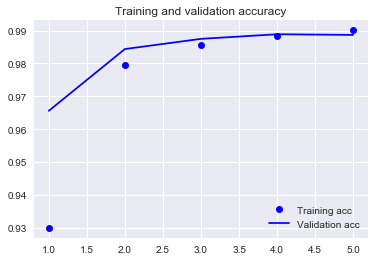

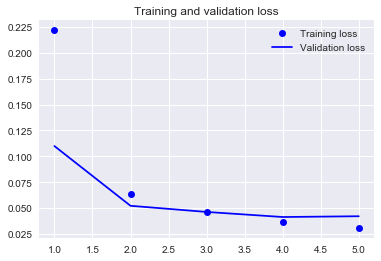

In [128]:
from mltools.plot import plotlib

myplt = plotlib()
myplt.plotAccuracy(history)

In [129]:
scores = model.evaluate(x_test, y_test, verbose=0)
print('Accuracy: {} %'.format(scores[1]*100))

Accuracy: 99.05000000000001 %


<h2>Model with data augmentation</h2>

Overfitting is caused by having too few samples to learn from, rendering you unable
to train a model that can generalize to new data. Given infinite data, your model Training a convnet from scratch on a small dataset would be exposed to every possible aspect of the data distribution at hand: you would never overfit. Data augmentation takes the approach of generating more training data from existing training samples, by augmenting the samples via a number of random transformations that yield believable-looking images. The goal is that at training time, your model will never see the exact same picture twice. This helps expose the model to more aspects of the data and generalize better.

In [135]:
datagen = ImageDataGenerator(featurewise_center = False,             # set input mean to 0 over the dataset
                             samplewise_center = False,              # set each sample mean to 0
                             featurewise_std_normalization = False,  # divide inputs by std of the dataset
                             samplewise_std_normalization = False,   # divide each input by its std
                             zca_whitening = False,                  # apply ZCA whitening
                             rotation_range = 10,                    # randomly rotate images in the range (degrees, 0 to 180)
                             width_shift_range = 0.2,                # randomly shift images horizontally (fraction of total width)
                             height_shift_range = 0.2,               # randomly shift images vertically (fraction of total height)
                             horizontal_flip = False,                # randomly flip images
                             vertical_flip = False)                  # randomly flip images

datagenerator = datagen.flow(x_train, y_train, batch_size = batch_size)

In [136]:
augmented_model = BuildModel(show = True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 3, 3, 64)          36928     
__________

In [137]:
augmented_model.compile(loss='categorical_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])

In [148]:
maxepochs = 30

In [149]:
augmented_model_details = augmented_model.fit_generator(datagenerator,
                                                        steps_per_epoch = len(x_train) // batch_size, # number of samples per gradient update
                                                        epochs = maxepochs, # number of iterations
                                                        validation_data= (x_val, y_val),
                                                        callbacks= checkpoint, 
                                                        verbose=1)

# augmented_model.save('model/weights/augmented_model.h5')

Epoch 1/30
781/781 [==============================] - 13s 16ms/step - loss: 0.0681 - acc: 0.9808 - val_loss: 0.0315 - val_acc: 0.9932
Epoch 2/30
781/781 [==============================] - 12s 16ms/step - loss: 0.0658 - acc: 0.9812 - val_loss: 0.0396 - val_acc: 0.9917
Epoch 3/30
781/781 [==============================] - 13s 16ms/step - loss: 0.0660 - acc: 0.9816 - val_loss: 0.0406 - val_acc: 0.9923
Epoch 4/30
781/781 [==============================] - 13s 16ms/step - loss: 0.0627 - acc: 0.9823 - val_loss: 0.0334 - val_acc: 0.9925
Epoch 5/30
781/781 [==============================] - 13s 16ms/step - loss: 0.0683 - acc: 0.9818 - val_loss: 0.0412 - val_acc: 0.9908
Epoch 6/30
781/781 [==============================] - 13s 16ms/step - loss: 0.0679 - acc: 0.9812 - val_loss: 0.0341 - val_acc: 0.9935
Epoch 7/30
781/781 [==============================] - 13s 17ms/step - loss: 0.0671 - acc: 0.9818 - val_loss: 0.0376 - val_acc: 0.9927
Epoch 8/30
781/781 [==============================] - 13s 17ms

In [150]:
scores = augmented_model.evaluate(x_test, y_test, verbose=0)
print('Accuracy: {} %'.format(scores[1]*100))

Accuracy: 99.07000000000001 %


In [151]:
def plot_model(model_details, prefix):

    plot1 = 'images/' + prefix + 'history_accuarcy.png'
    plot2 = 'images/' + prefix + 'history_loss.png'
    
    # Create sub-plots
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # Summarize history for accuracy
    axs[0].plot(range(1,len(model_details.history['acc'])+1),model_details.history['acc'])
    axs[0].plot(range(1,len(model_details.history['val_acc'])+1),model_details.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_details.history['acc'])+1),len(model_details.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    fig.savefig(plot1)
    
    # Summarize history for loss
    axs[1].plot(range(1,len(model_details.history['loss'])+1),model_details.history['loss'])
    axs[1].plot(range(1,len(model_details.history['val_loss'])+1),model_details.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_details.history['loss'])+1),len(model_details.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    fig.savefig(plot2)
    
    # Show the plot
    plt.show()

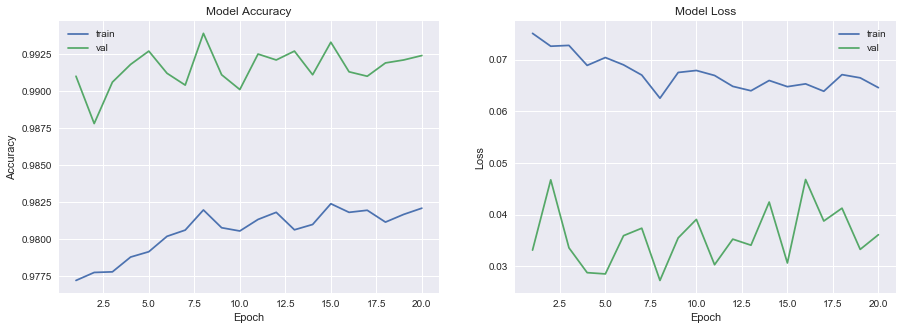

In [147]:
plot_model(augmented_model_details, 'augmentation_')

In [155]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau

# checkpoint        = ModelCheckPoint(modelname = 'model/weights/modelMNIST.h5')
# reducelronplateau = ReduceLROnPlateau()
reducelronplateau = ReduceLROnPlateau(monitor  = 'val_loss', patience = 10, verbose  = 1, factor   = 0.1, min_lr   = 0.00001)

In [158]:
augmented_model_details = augmented_model.fit_generator(datagenerator,
                                                        steps_per_epoch = len(x_train) // batch_size, # number of samples per gradient update
                                                        epochs = maxepochs, # number of iterations
                                                        validation_data= (x_val, y_val),
                                                        callbacks= [reducelronplateau])

Epoch 1/30
781/781 [==============================] - 13s 16ms/step - loss: 0.0753 - acc: 0.9792 - val_loss: 0.0680 - val_acc: 0.9909
Epoch 2/30
781/781 [==============================] - 13s 16ms/step - loss: 0.0830 - acc: 0.9784 - val_loss: 0.0383 - val_acc: 0.9927
Epoch 3/30
781/781 [==============================] - 13s 16ms/step - loss: 0.0778 - acc: 0.9793 - val_loss: 0.0659 - val_acc: 0.9910
Epoch 4/30
781/781 [==============================] - 13s 16ms/step - loss: 0.0764 - acc: 0.9795 - val_loss: 0.0469 - val_acc: 0.9903
Epoch 5/30
781/781 [==============================] - 13s 16ms/step - loss: 0.0809 - acc: 0.9789 - val_loss: 0.1346 - val_acc: 0.9867
Epoch 6/30
781/781 [==============================] - 13s 16ms/step - loss: 0.0829 - acc: 0.9786 - val_loss: 0.0981 - val_acc: 0.9879
Epoch 7/30
781/781 [==============================] - 13s 16ms/step - loss: 0.0821 - acc: 0.9789 - val_loss: 0.3649 - val_acc: 0.9661
Epoch 8/30
781/781 [==============================] - 13s 16ms

In [159]:
scores = augmented_model.evaluate(x_test, y_test, verbose=0)
print('Accuracy: {} %'.format(scores[1]*100))

Accuracy: 99.28 %


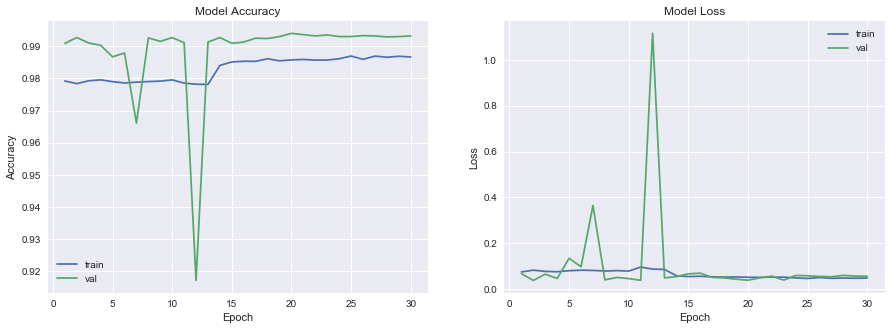

In [160]:
plot_model(augmented_model_details, 'augmentation_')